<center><h1>Yang_Xu_HW1</h1></center>
<br>
<center><font size="4">Vertebral Column Data</font></center>

#### yxu95543 
#### 7243-0476-68

### (a) Download Data

Package imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score


import warnings
warnings.filterwarnings("ignore")


Get the Vertebral Column Data Set

In [41]:

# Load local column_2C.dat (uploaded)
data_df = pd.read_csv("../data/vertebral_column_data/column_2C.dat", sep=r"\s+", header=None,
                      names=["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle",
                             "sacral_slope","pelvic_radius","spondylolisthesis_grade","label_str"])
data_df["label"] = data_df["label_str"].map({"NO":0, "AB":1})

features = data_df.columns[:-2]
X_all = data_df[features].to_numpy(float)
y_all = data_df["label"].to_numpy(int)

data_df.head()


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,spondylolisthesis_grade,label_str,label
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB,1
1,39.06,10.06,25.02,29.00,114.41,4.56,AB,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB,1
3,69.30,24.65,44.31,44.64,101.87,11.21,AB,1
4,49.71,9.65,28.32,40.06,108.17,7.92,AB,1


### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

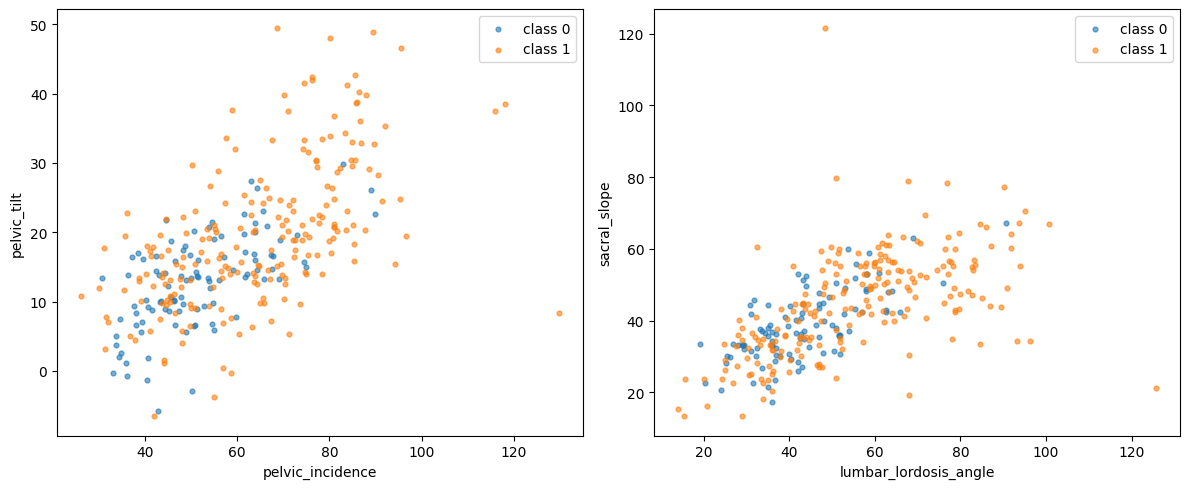

In [42]:
import matplotlib.pyplot as plt

# (b.i) scatterplots
pairs = [("pelvic_incidence","pelvic_tilt"),("lumbar_lordosis_angle","sacral_slope")]
fig, axes = plt.subplots(1, len(pairs), figsize=(6*len(pairs), 5))
if len(pairs) == 1:
    axes = [axes]
for ax, (x, y) in zip(axes, pairs):
    for cls in [0, 1]:
        sub = data_df[data_df["label"] == cls]
        ax.scatter(sub[x], sub[y], s=12, alpha=0.6, label=f"class {cls}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend()
plt.tight_layout()
plt.show()


#### ii. Boxplots

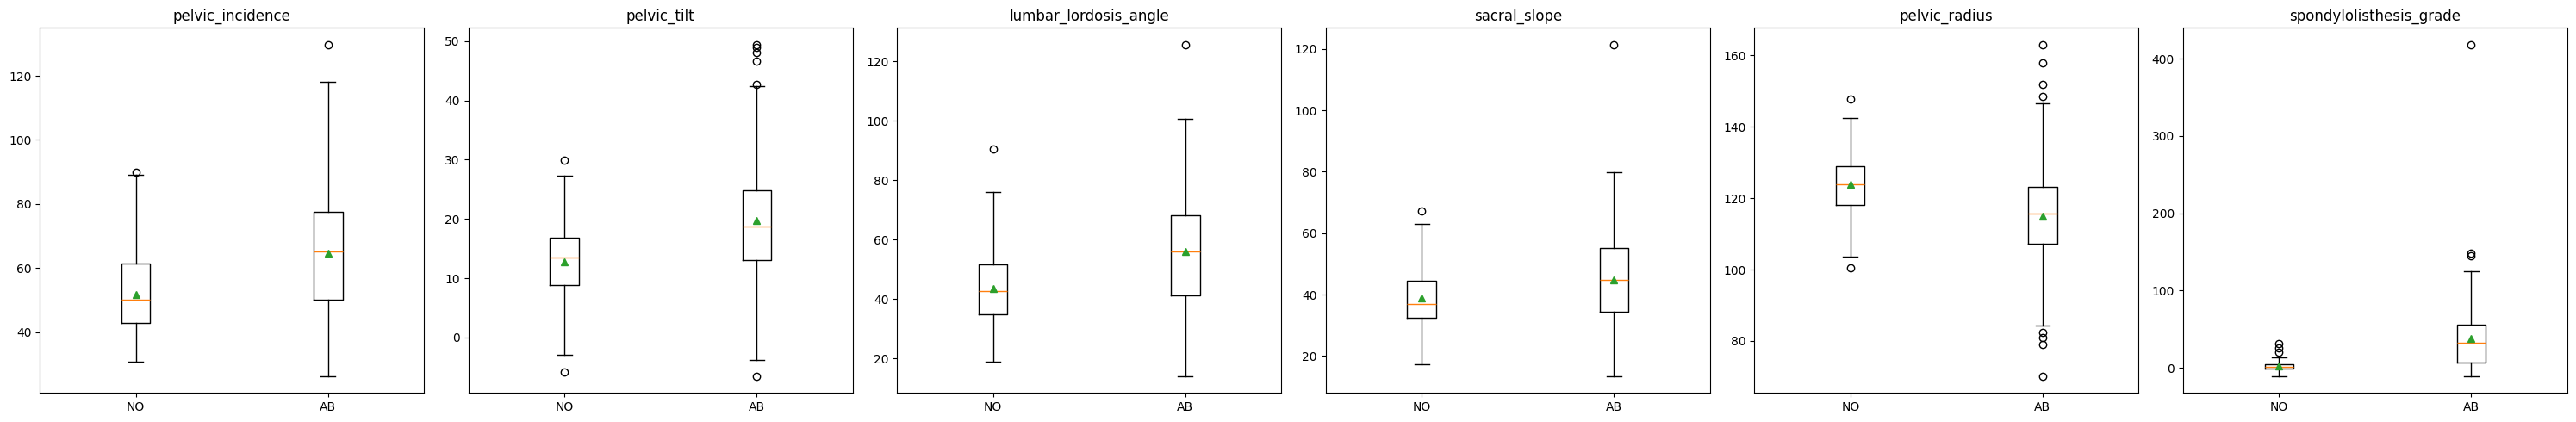

In [43]:

# (b.ii) boxplots
num_feats = len(features)
fig, axes = plt.subplots(1, num_feats, figsize=(5*num_feats, 5))
if num_feats == 1:
    axes = [axes]
for ax, feat in zip(axes, features):
    grouped = [data_df.loc[data_df["label"]==c, feat].values for c in [0,1]]
    ax.boxplot(grouped, labels=["NO","AB"], showmeans=True)
    ax.set_title(feat)
plt.tight_layout()
plt.show()


#### iii. Split Data Set

In [44]:
df0 = data_df[data_df["label"]==0].reset_index(drop=True)
df1 = data_df[data_df["label"]==1].reset_index(drop=True)
train_df = pd.concat([df0.iloc[:70], df1.iloc[:140]], ignore_index=True)
test_df  = pd.concat([df0.iloc[70:], df1.iloc[140:]], ignore_index=True)
X_train, y_train = train_df[features].to_numpy(float), train_df["label"].to_numpy(int)
X_test, y_test   = test_df[features].to_numpy(float),  test_df["label"].to_numpy(int)
print(X_train.shape, X_test.shape)

(210, 6) (100, 6)


### (c) Classification

#### i. Euclidean Metric

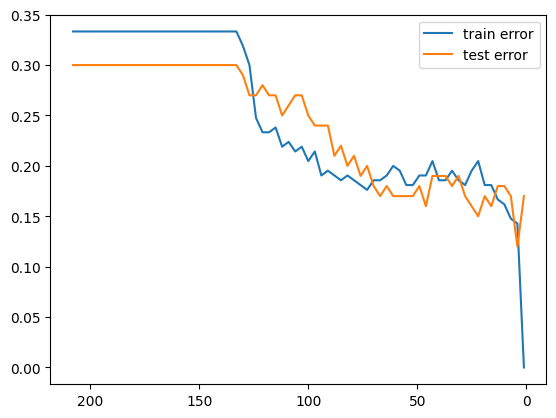

best k* 4 test error 0.12
Confusion matrix:
 [[22  8]
 [ 4 66]]
TPR 0.9428571428571428 TNR 0.7333333333333333 Precision 0.8918918918918919 F1 0.9166666666666667


In [45]:

# (c.i, ii) error vs k
k_values = [k for k in range(208,0,-3) if k<=len(X_train)]
train_err, test_err = [], []
best_k, best_te, best_model = None, 1.0, None
for k in k_values:
    model = Pipeline([("scaler", StandardScaler()),
                      ("knn", KNeighborsClassifier(n_neighbors=k, metric="euclidean"))])
    model.fit(X_train, y_train)
    ytr = model.predict(X_train); yte = model.predict(X_test)
    tr_e = 1-accuracy_score(y_train,ytr); te_e=1-accuracy_score(y_test,yte)
    train_err.append(tr_e); test_err.append(te_e)
    if te_e<best_te:
        best_te,best_k,best_model=te_e,k,model

plt.plot(k_values,train_err,label="train error")
plt.plot(k_values,test_err,label="test error")
plt.gca().invert_xaxis(); plt.legend(); plt.show()
print("best k*",best_k,"test error",best_te)

# confusion matrix and metrics
y_pred=best_model.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
tn,fp,fn,tp=cm.ravel()
TPR=tp/(tp+fn); TNR=tn/(tn+fp)
print("Confusion matrix:\n",cm)
print("TPR",TPR,"TNR",TNR,"Precision",precision_score(y_test,y_pred),"F1",f1_score(y_test,y_pred))

#### iii. Learning Curve

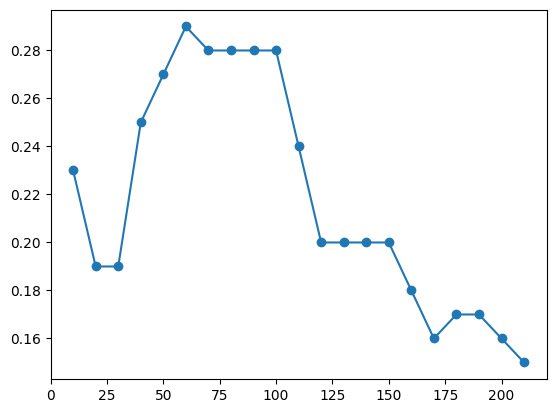

In [46]:
N_values=list(range(10,211,10)); best_test_errors=[]
train0=train_df[train_df["label"]==0].reset_index(drop=True)
train1=train_df[train_df["label"]==1].reset_index(drop=True)
for N in N_values:
    n0=int(np.floor(N/3)); n1=N-n0
    sub=pd.concat([train0.iloc[:n0],train1.iloc[:n1]],ignore_index=True)
    X_sub,y_sub=sub[features].to_numpy(float),sub["label"].to_numpy(int)
    ks=list(range(1,N+1,5))
    min_te=1.0
    for k in ks:
        model=Pipeline([("scaler",StandardScaler()),
                        ("knn",KNeighborsClassifier(n_neighbors=k))])
        model.fit(X_sub,y_sub)
        te=1-accuracy_score(y_test,model.predict(X_test))
        if te<min_te:min_te=te
    best_test_errors.append(min_te)
plt.plot(N_values,best_test_errors,marker="o"); plt.show()

### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.
##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.
##### C. Chebyshev Distance With p -> infinity.
#### ii. Mahalanobis Distance.

In [47]:
from sklearn.covariance import LedoitWolf
from numpy.linalg import inv

k_grid_196=list(range(1,197,5))
def best_error(metric,params=None,fixed_k=None):
    ks=[fixed_k] if fixed_k else k_grid_196
    min_te, best_k=1.0,None
    for k in ks:
        model=Pipeline([("scaler",StandardScaler()),
                        ("knn",KNeighborsClassifier(n_neighbors=k,metric=metric,**(params or {})))])
        model.fit(X_train,y_train)
        te=1-accuracy_score(y_test,model.predict(X_test))
        if te<min_te:min_te, best_k=te,k
    return min_te,best_k

# Manhattan
err_manh,k_manh=best_error("manhattan")
# Minkowski sweep
log10_ps=np.arange(0.1,1.01,0.1); p_vals=10**log10_ps; errs=[]
for p in p_vals:
    model=Pipeline([("scaler",StandardScaler()),
                    ("knn",KNeighborsClassifier(n_neighbors=k_manh,metric="minkowski",p=float(p)))])
    model.fit(X_train,y_train)
    errs.append(1-accuracy_score(y_test,model.predict(X_test)))
best_p=p_vals[np.argmin(errs)]; err_mink=min(errs)
# Chebyshev
err_cheb,k_cheb=best_error("chebyshev")
# Mahalanobis
cov=LedoitWolf().fit(X_train).covariance_; VI=inv(cov)
err_maha,k_maha=best_error("mahalanobis",params={"metric_params":{"VI":VI}})

pd.DataFrame({"Distance":["Manhattan","Minkowski","Chebyshev","Mahalanobis"],
              "Best k":[k_manh,k_manh,k_cheb,k_maha],
              "Test error":[err_manh,err_mink,err_cheb,err_maha]})

,Distance,Best k,Test error
0,Manhattan,6,0.14
1,Minkowski,6,0.16
2,Chebyshev,1,0.15
3,Mahalanobis,1,0.20


### (e) Weighted Decision

In [48]:
# (e) The majority polling decision can be replaced by weighted decision, in which the
# weight of each point in voting is inversely proportional to its distance from the
# query/test data point. In this case, closer neighbors of a query point will have
# a greater influence than neighbors which are further away. Use weighted voting
# with Euclidean, Manhattan, and Chebyshev distances and report the best test
# errors when k ∈{1, 6, 11, 16, . . . , 196}.

results = []
for metric in ["euclidean", "manhattan", "chebyshev"]:
    min_te, best_k = 1.0, None
    for k in k_grid_196:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k, metric=metric, weights="distance"))
        ])
        model.fit(X_train, y_train)
        te = 1 - accuracy_score(y_test, model.predict(X_test))
        if te < min_te:
            min_te, best_k = te, k
    results.append({"Metric": metric, "Best k": best_k, "Test error": min_te})

pd.DataFrame(results)

,Metric,Best k,Test error
0,euclidean,21,0.15
1,manhattan,6,0.15
2,chebyshev,1,0.15


### (f) Training Error Rate

In [49]:
min_tr,at_k=1.0,None
for k in k_grid_196:
    model=Pipeline([("scaler",StandardScaler()),
                    ("knn",KNeighborsClassifier(n_neighbors=k))])
    model.fit(X_train,y_train)
    tr_err=1-accuracy_score(y_train,model.predict(X_train))
    if tr_err<min_tr:min_tr,at_k=tr_err,k
print("Lowest training error",min_tr,"at k",at_k)

Lowest training error 0.0 at k 1
